# Convolutional Neural Network


convolution을 사용하였던 최초의 NN

## 실습 목표
-----
- CNN을 구성하는 주요 연산을 이해하고, 신경망을 설계한다.
- AlexNet을 사용하여 이미지를 학습하고 10개의 카테고리를 갖는 이미지를 분류하는 이미지 분류기를 생성한다. (데이터셋: [CIFAR](https://pytorch.org/vision/0.9/datasets.html#cifar))
- 이미지 증강을 수행하여 모델의 성능을 높이는 방법을 이해한다.
- Confusion Matrix를 생성하여 분류 정확도를 확인한다.
- **reference**
    - https://tutorials.pytorch.kr/beginner/basics/buildmodel_tutorial.html
    - https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html
    - https://medium.com/@djin31/how-to-plot-wholesome-confusion-matrix-40134fd402a8

## 문제 정의
----
- AlexNet
    - AlexNet competed in the ImageNet Large Scale Visual Recognition Challenge on September 30, 2012. The network achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up. 


![AlexNet](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Comparison_image_neural_networks.svg/720px-Comparison_image_neural_networks.svg.png)

## 주요 코드
----


### 1. nn.Conv2d()
- `in_channels`
- `out_channels`
- `kernel_size`
- `stride=1`
- `padding=0`


sample code
```
nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5),
```


### 2. nn.MaxPool2d()
- `kernel_size`
- `stride=None`
- `padding=0`


sample code
```
nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
```


### 3. tensor.view()
- `reshape` 배열의 구조를 바꾸어주는 연산
```
>>> x = torch.randn(4, 4)
>>> x.size()
torch.Size([4, 4])
>>> y = x.view(16)
>>> y.size()
torch.Size([16])
>>> z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
>>> z.size()
torch.Size([2, 8])
```


AlexNet 코드 미리보기([구조](https://en.wikipedia.org/wiki/File:Comparison_image_neural_networks.svg))


```
class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
```



### 4. 이미지 증강

```
mean = train_img.data.mean(axis=(0,1,2)) / 255
std = test_img.data.std(axis=(0,1,2)) / 255
print(f'평균:{mean}, 표준편차:{std}')

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
    transforms.RandomCrop(size=train_img.data.shape[1], padding=4),
    transforms.RandomHorizontalFlip(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_img2 = datasets.CIFAR10(
    root = 'data',
    train = True,
    download = True,
    transform = transform_train,
)

test_img2 = datasets.CIFAR10(
    root = 'data',
    train = False,
    download = True,
    transform = transform_test,
)
```

### 5. Confusion Matrix
```
from sklearn.metrics import confusion_matrix
```

## CIFAR Classifier(AlexNet)
----
CIFAR 데이터셋을 사용하여 이미지에 포함된 object가 무엇인지 분류하는 이미지 분류기를 생성해봅니다.


### [Step1] Load libraries & Datasets

In [40]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.transforms.functional import to_pil_image # 불러온 데이터 이미지 시각화를 위해 사용

In [41]:
# CIFAR 데이터 불러오기
train_img = datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)
test_img = datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

Files already downloaded and verified
Files already downloaded and verified


### [Step2] Data preprocessing

불러온 이미지의 증강을 통해 학습 정확도를 향상시키도록 합니다.

* RandomCrop (확대) 
* RandomHorizontalFlip (수평이동)
* Normalize (일반화)

In [42]:
mean=train_img.data.mean(axis=(0,1,2))/255
std=train_img.data.std(axis=(0,1,2))/255
print(f'평균:{mean}, 표준편차:{std}')

평균:[0.49139968 0.48215841 0.44653091], 표준편차:[0.24703223 0.24348513 0.26158784]


In [43]:
transform_train=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomCrop(size=train_img.data.shape[1],padding=4),
    transforms.RandomHorizontalFlip(),
])
# train에서는 변형하여도 되지만 test에서는 안됨! 그렇기때문에 normal + 자료형 변환만 쓴다.

transform_test=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
])

In [44]:
train_img2=datasets.CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform_train
)

test_img2=datasets.CIFAR10(
    root='data',
    train=False,
    download=True,
    transform= transform_test,
)
# 앞으로 데이터를 불러올때 먼저 transform을 먼저 선언한 이후 데이터를 불러오는 과정에 transform을 쓰면 더 편리하다!

Files already downloaded and verified
Files already downloaded and verified


### [Step3] Set hyperparameters

In [45]:
EPOCH=10
BATCH_SIZE=128
LR=1e-3
DEVICE= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using DEVICE: {DEVICE}')

Using DEVICE: cuda


### [Step4] Create DataLoader

In [46]:
# Data Loader 만들기
train_loader=DataLoader(train_img2, batch_size=BATCH_SIZE,shuffle=True)
test_loader=DataLoader(test_img2, batch_size=BATCH_SIZE, shuffle=False)

#### EDA

In [47]:
print(train_img, '\n-----------------------------\n', test_img)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor() 
-----------------------------
 Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [48]:
seex,seey=train_img[0]
print(f' 1번 자료[shape: {seex.size()} label:{seey}')
train_img[0]

 1번 자료[shape: torch.Size([3, 32, 32]) label:6


(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [49]:
train_features, train_labels=next(iter(train_loader))
print(f'Feature batch shape:{train_features.size()}')
print(f'Labels batch shape:{train_labels.size()}')

Feature batch shape:torch.Size([128, 3, 32, 32])
Labels batch shape:torch.Size([128])


In [50]:
labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

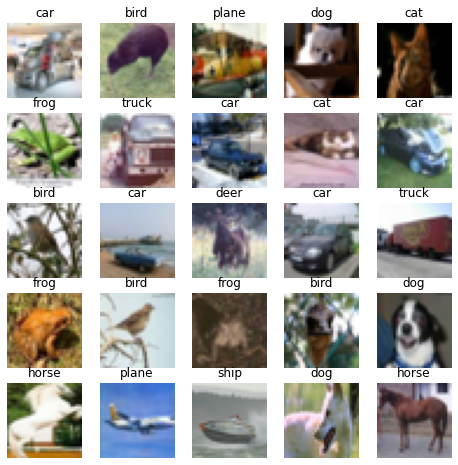

In [51]:
figure=plt.figure(figsize=(8,8))
cols, rows= 5,5

for i in range(1,cols*rows+1):
  sample_idx=torch.randint(len(train_img),size=(1,)).item()
  img, label= train_img[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(to_pil_image(img))
plt.show()

### [Step5] Set Network Structure

In [52]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 4096),
            nn.Dropout(0.5),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        print(x.size())
        x = self.classifier(x)
        return x

### [Step6] Create Model instance

In [53]:
# Model instance 생성
model=AlexNet().to(DEVICE)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=4096, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=4096, out_fea

### [Step7] Model compile

In [54]:
loss=nn.CrossEntropyLoss()
# Optimizer
optimizer= torch.optim.Adam(model.parameters(), lr=LR)

### [Step8] Set train loop

In [55]:
def train(train_loader, model, loss_fn, optimizer):
    model.train()
    
    size = len(train_loader.dataset)
    
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(DEVICE), y.to(DEVICE)
        pred = model(X)
        print(f'여기',pred.size(), y.size())
        # 손실 계산
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}]/{size:5d}')

### [Step9] Set test loop

In [56]:
def test(test_loader, model, loss_fn):
    model.eval()

    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(DEVICE), y.to(DEVICE)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:8f}\n")

### [Step10] Run model

In [57]:
for i in range(EPOCH) :
    print(f"Epoch {i+1} \n------------------------")
    train(train_loader, model, loss, optimizer)
    test(test_loader, model, loss)
print("Done!")

Epoch 1 
------------------------
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
loss: 2.299201  [    0]/50000
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([128, 256])
여기 torch.Size([128, 10]) torch.Size([128])
torch.Size([

KeyboardInterrupt: ignored

### [Step11] Confusion Matrix

In [ ]:
import itertools
def plot_confusion_matrix(cm, target_names=None, cmap=None, 
                          normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f};\
                         misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

model.eval()
ylabel = []
ypred_label = []

for batch_idx, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
    outputs = model(inputs)
    _, predicted = outputs.max(1)
    ylabel = np.concatenate((ylabel, targets.cpu().numpy()))
    ypred_label = np.concatenate((ypred_label, predicted.cpu().numpy()))

cnf_matrix = confusion_matrix(ylabel, ypred_label)

In [ ]:
plot_confusion_matrix(cnf_matrix, 
                      target_names=labels_map.values(), 
                      title='Confusion matrix, trained by AlexNet')
# True label를 예측하였을 때 어떤 것과 가장 헷갈리게 분류하였는가를 확인하기 위한 시각화 작업